# Logistic Regression

In [36]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import sklearn
from collections import defaultdict
from tqdm.notebook import tqdm
from ipywidgets import interact
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Part 1 - 1D Toy example
Consider the case where random numbers are created by two different Gaussian distributions with identical variance. We also know the labels from which distribution each number was originating from. The generated data could, for example, represent how many days a student has learned for the ML exam and the target variable is if they have passed.

In [37]:
students_passed = np.random.normal(5,0.7,100)
students_passed[1:20]

array([4.82980843, 4.29885886, 4.2656619 , 4.87064565, 5.19610568,
       4.514268  , 4.78822065, 5.58654596, 3.70774639, 5.35244535,
       4.48903685, 4.85978336, 4.96578772, 4.85802219, 5.21346197,
       4.25011346, 4.97616261, 5.63230764, 3.78084404])

In [38]:
students_failed = np.random.normal(2,0.7,100)
students_failed[1:20]

array([1.8451209 , 1.87200732, 1.01656932, 3.60255332, 1.04412621,
       2.05333268, 2.3381401 , 2.74707691, 1.69472329, 1.24423282,
       2.55200036, 1.99511493, 1.47469574, 2.99249006, 2.01799275,
       1.18285795, 1.56173002, 1.69763848, 1.05627793])

To use this data for a logistic regression model, we combine the vectors $\text{students_passed}$ and $\text{students_failed}$ into a vector $X$ and create the corresponding labels $y$.

In [39]:
# label: failed
zeros = [0]*100
# label: passed
ones = [1]*100

X = np.concatenate((students_passed, students_failed))
y = np.concatenate((ones, zeros))

We plot both type of points in a scatter plot, where the points generated by the first distribution are plotted in blue have the label $y=0$, while the points of the second distribution are plotted in orange at $y=1$.

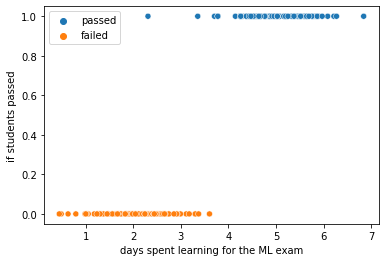

In [40]:
legend_map = {0: 'failed', 1: 'passed'}
ax = sns.scatterplot(X, y, hue=pd.Series(y).map(legend_map))
ax.set_xlabel('days spent learning for the ML exam')
ax.set_ylabel('if students passed')
plt.show()

Now we would like to determine, if an arbitrary previously unseen point belongs rather to distribution 1 or two distribution 2. For that, we want to employ logistic regression. Similar to linear regression, we first consider a model with a single independent variable and two parameters $\theta_0$ and $\theta_1$.

The probability, that $x$ belongs to either of the two classes is determined using the sigmoid function.

$$
  \sigma(x) = \frac{1}{1+e^{-(\theta_0 + \theta_1x)}}
$$


> Implement the sigmoid function

In [41]:
def sigmoid(z):
    # START YOUR CODE
    s = 1 / (1 + np.exp(-z))
    # END YOUR CODE
    return s

In [42]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

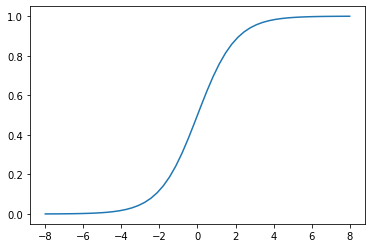

In [43]:
x = np.linspace(-8, 8)
plt.plot(x, sigmoid(x))

> Implement the `predict` function

In [44]:
def predict(X, theta0, theta1):
    # START YOUR CODE
    y_pred = sigmoid(theta0 + (X*theta1))
    # END YOUR CODE
    return y_pred

In [45]:
def predict(X, theta0, theta1):
    z = theta0 +  theta1 * X
    y_pred = sigmoid(z)
    return y_pred

In [46]:
theta0 = 1.0
theta1 = 1.0

y_pred = predict(X, theta0, theta1)
y_pred[0:20]

array([0.99720623, 0.99706997, 0.99502756, 0.99486058, 0.99718688,
       0.99796679, 0.99598729, 0.99694593, 0.9986231 , 0.99105563,
       0.99826055, 0.99588518, 0.99715625, 0.99744154, 0.99715125,
       0.99800171, 0.99478046, 0.99746788, 0.99868461, 0.99168087])

### Visualize Decision Boundary
The decision boundary is given by the x such that: $-\theta_0-\theta_1 x=0$.

We can solve this equation for x: $x=-\frac{\theta_0}{\theta_1}$
Now let us plot the decision boundary and the logistic function

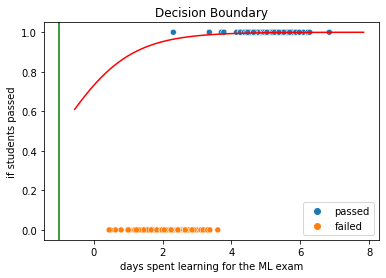

In [47]:
def plot_decision_boundary(X, theta0, theta1, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    x = np.arange(X.min()-1, X.max()+1, 0.01).reshape(-1,1)
    y_pred = predict(x, theta0, theta1)
    ax.plot(x, y_pred, color="r")
    ax.axvline(-theta0/theta1, color="g")
    ax.set_title("Decision Boundary")
    
legend_map = {0: 'failed', 1: 'passed'}
ax = sns.scatterplot(X, y, hue=pd.Series(y).map(legend_map))
ax.set_xlabel('days spent learning for the ML exam')
ax.set_ylabel('if students passed')
plot_decision_boundary(X, theta0, theta1, ax)
plt.show()

### Cost function
The cross-entropy cost function $J(\boldsymbol\theta)$, where $\boldsymbol\theta=\left(\theta_0,\theta_1\right)$ is given by

$$
    J(\boldsymbol\theta) =
      - \frac{1}{n} \sum_{i=1}^n%
        \left[y_i\log h(\boldsymbol\theta,\mathbf{X_i})
            + (1-y_i)\log\left(
               1-h(\boldsymbol\theta,\mathbf{X_i})\right)\right]
$$

where $h(\boldsymbol\theta,\mathbf{X_i})=\sigma\left(\mathbf{X_i}^T\boldsymbol\theta\right)=\sigma\left(\theta_0+\theta_1 x\right)$ and $\sigma$ is the sigmoid function.

> Implement the cost function. Verify your code by running the next cell.

In [48]:
def cost_function(y, y_pred):
    # START YOUR CODE
    n = y.shape[0]
    cost = - (1/n) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1- y_pred))
    
    # END YOUR CODE
    return cost

In [49]:
def cost_function(y, y_pred):
    n = y.shape[0]
    cost = -(1.0 / n) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    return cost

If your code is correct, you should be able to run the following cell:

In [50]:
y_assert = np.array([1, 0, 0])
y_pred = np.array([0.98, 0.2, 0.6])

expected_cost = 0.38654566350196135
actual_cost = cost_function(y_assert, y_pred)

np.testing.assert_almost_equal(actual_cost, expected_cost, decimal=3)

### Gradients
For applying gradient descent, we define the gradient.

In [51]:
def gradient(X, y, theta0, theta1):
    y_pred = predict(X, theta0, theta1)
    diff = y_pred - y
    
    n = len(X)
    grad_theta0 = np.sum(diff) / n
    grad_theta1 = np.dot(diff, X.T) / n
    
    return grad_theta0, grad_theta1

### Gradient Descent
Now we are ready to determine the optimal values for the parameters $\theta_0$ and $\theta_1$ using the gradient descent algorithm.


$$
\mathbf{Repeat}\;\mathrm{(until}\;\mathrm{convergence)} \left\{\right.
  \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\\
      \boldsymbol\theta_{k+1} = \boldsymbol\theta_{k}-\alpha\frac{1}{n}\sum_{i=1}^n
          \left(h(\boldsymbol\theta_k,\mathbf{x}^{(i)})-y^{(i)}\right)\mathbf{x}^{(i)},
          \quad k = 0,\,1,\,2,\,3,\,\ldots,\mathtt{kmax}\\
    \left.\right\}\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad
$$



> Implement the `fit` function

In [52]:
def fit(X, y, alpha, num_epochs, display_every=10):
    theta0 = 0.0
    theta1 = np.random.randn()
    
    hist = defaultdict(list)
    for i in tqdm(range(num_epochs)):
        # START YOUR CODE
        # calculate gradients
        grad_theta0, grad_theta1 = gradient(X, y, theta0, theta1)
        
        # update model parameters theta0 and theta1
        theta0 = theta0 - alpha * grad_theta0
        theta1 = theta1 - alpha * grad_theta1
        
        # calculate the current costs
        y_pred = predict(X, theta0, theta1)
        curr_cost = cost_function(y, y_pred)
 
        # END YOUR CODE         
        hist["cost"].append(curr_cost)
        hist["theta0"].append(theta0)
        hist["theta1"].append(theta1)
        
        if i == 0 or (i+1) % display_every == 0:
            print("Epoch {} -  cost: {}".format(i+1, curr_cost))
        
    return theta0, theta1, hist

In [53]:
def fit(X, y, alpha, num_epochs, display_every=10):
    theta0 = 0.0
    theta1 = np.random.randn()
    
    hist = defaultdict(list)
    for i in tqdm(range(num_epochs)):
        # calculate gradients
        grad_theta0, grad_theta1 = gradient(X, y, theta0, theta1)
        
        # update model parameters theta0 and theta1
        theta0 = theta0 - alpha * grad_theta0
        theta1 = theta1 - alpha * grad_theta1
        
        # calculate the current costs
        y_pred = predict(X, theta0, theta1)
        curr_cost = cost_function(y, y_pred)
        
        hist["cost"].append(curr_cost)
        hist["theta0"].append(theta0)
        hist["theta1"].append(theta1)
        
        if i == 0 or (i+1) % display_every == 0:
            print("Epoch {} -  cost: {}".format(i+1, curr_cost))
        
    return theta0, theta1, hist

#### Plot validation curve
We implement a function that allows us to plot the validation curve.

In [54]:
def plot_validation_curve(costs, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_ylabel("Cost")
    ax.set_title("Validation Curve")
    ax.set_xlabel("Epochs")
    ax.plot(costs)

#### Run gradient descent algorithm
Let's run the gradient descent algorithm!

Epoch 1 -  cost: 0.8650861062040659
Epoch 1000 -  cost: 0.12645644295480118
Epoch 2000 -  cost: 0.09128260573007176
Epoch 3000 -  cost: 0.07838980189379414
Epoch 4000 -  cost: 0.07168996983668637
Epoch 5000 -  cost: 0.0676024787910665
Epoch 6000 -  cost: 0.06486498760934226
Epoch 7000 -  cost: 0.06291593048213912
Epoch 8000 -  cost: 0.061466821851440444
Epoch 9000 -  cost: 0.06035408585746584
Epoch 10000 -  cost: 0.05947802680586122
Epoch 11000 -  cost: 0.05877443196910926
Epoch 12000 -  cost: 0.05820009709153997
Epoch 13000 -  cost: 0.057724905665603864
Epoch 14000 -  cost: 0.05732724041127346
Epoch 15000 -  cost: 0.056991197739256594
Epoch 16000 -  cost: 0.056704829189950595
Epoch 17000 -  cost: 0.0564589936456874
Epoch 18000 -  cost: 0.05624658641649602
Epoch 19000 -  cost: 0.05606200838881401
Epoch 20000 -  cost: 0.05590079239492672
Epoch 21000 -  cost: 0.05575933509637693
Epoch 22000 -  cost: 0.05563470123287118
Epoch 23000 -  cost: 0.05552447847376977
Epoch 24000 -  cost: 0.05542

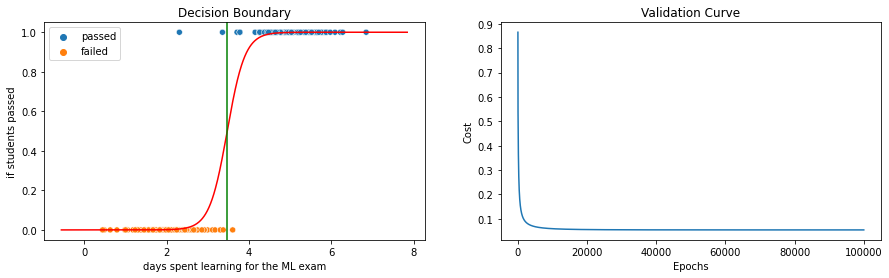

In [55]:
alpha = 0.1
num_epochs = 100000

theta0, theta1, hist = fit(X, y, alpha, num_epochs, display_every=1000)

fig, ax = plt.subplots(ncols=2, figsize=(15,4))

# scatter plot
legend_map = {0: 'failed', 1: 'passed'}
ax[0] = sns.scatterplot(X, y, hue=pd.Series(y).map(legend_map), ax=ax[0])
ax[0].set_xlabel('days spent learning for the ML exam')
ax[0].set_ylabel('if students passed')
plot_decision_boundary(X, theta0, theta1, ax[0])

# validation curve
plot_validation_curve(hist["cost"], ax=ax[1])

### Visualize Learning 
Let's visualize how the decision boundary changes over time.

In [56]:
@interact(epoch=(0, len(hist["theta0"]), 100))
def visualize_learning(epoch=100):
    legend_map = {0: 'failed', 1: 'passed'}
    ax = sns.scatterplot(X, y, hue=pd.Series(y).map(legend_map))
    ax.set_xlabel('days spent learning for the ML exam')
    ax.set_ylabel('if students passed')
    if epoch == 0:
        epoch += 1
    plot_decision_boundary(X, hist["theta0"][epoch-1], hist["theta1"][epoch-1], ax)
    plt.show()


interactive(children=(IntSlider(value=100, description='epoch', max=100000, step=100), Output()), _dom_classes…

### Metrics
Let's calculate the accuracy

In [57]:
y_pred = predict(X, theta0, theta1)
y_pred[0:10]

array([0.99851377, 0.99814688, 0.97879561, 0.97536152, 0.99846547,
       0.99965925, 0.99206809, 0.99775451, 0.99994404, 0.74966059])

We label a point as 1 if the predicted value is larger than 0.5

In [58]:
# y_pred_class = ...

In [59]:
y_pred_class = y_pred > 0.5

In [60]:
accuracy = accuracy_score(y, y_pred_class)

print("Accuracy: ", accuracy)

Accuracy:  0.985


## Part 2 - Multiple Logistic Regression - Toy example
In the second part, logistic regression is used in a 2D toy example. Here the data is loaded from a `.csv` file, but it was also generated artificially for illustration purposes. Here the data can, for example, correspond to
* feature 1: days spent learning for the ML exam
* feature 2: days spent working in the ML domain (prior experience)
* target variable: if students have passed the exam

In [61]:
df = pd.read_csv("classification_data.csv", header=None)
df.columns = ['days spent learning', 'prior experience', 'exam passed']
df.head()

,days spent learning,prior experience,exam passed
0,4.855064,9.639962,1
1,8.625440,0.058927,0
2,3.828192,0.723199,0
3,7.150955,3.899420,1
4,6.477900,8.198181,1


In [62]:
n = len(df)
X_2d = df.values[:, 0:2]
y_2d = df.values[:,2]

Split the data into training and test set.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_2d, y_2d, test_size=0.1)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

X_train: (90, 2)
y_train: (90,)


### Predict function
The first step is to modify our `predict` function to handle multiple thetas.

In [64]:
def predict(X, bias, thetas):
    # START YOUR CODE
    z = bias + np.dot(X,thetas)
    y_pred = 1 / (1 + np.exp(-z))
    
    # END YOUR CODE
    return y_pred

In [65]:
def predict(X, bias, thetas):
    z = bias + np.dot(X, thetas)
    y_pred = sigmoid(z)
    return y_pred

### Gradient function
Let's modify the `gradient` function.

In [66]:
def gradient(X, y, bias, thetas):
    # START YOUR CODE
    y_pred = predict(X, bias, thetas)
    diff = y_pred - y


    n = len(X)
    grad_bias = np.sum(diff) / n
    grad_thetas = np.dot(diff, X) / n 
    # END YOUR CODE
    return grad_bias, grad_thetas

In [67]:
def gradient(X, y, bias, thetas):
    y_pred = predict(X, bias, thetas)
    diff = y_pred - y
    
    n = len(X)
    grad_bias = np.sum(diff) / n
    grad_thetas = np.dot(diff, X) / n
    
    return grad_bias, grad_thetas

### Gradient descent algorithm


In [69]:
def fit(X, y, alpha, num_epochs, display_every=100):
    bias = 0.0
    thetas = np.random.randn(*(1, X.shape[1])).reshape(-1)
        
    hist = defaultdict(list)
    for epoch in tqdm(range(1, num_epochs+1)):
        # calculate gradients
        grad_bias, grad_thetas = gradient(X, y, bias, thetas)
        
        # update model parameters
        bias = bias - alpha * grad_bias
        thetas = thetas - alpha * grad_thetas
        
        # calculate the current costs
        y_pred = predict(X, bias, thetas)
        curr_cost = cost_function(y, y_pred)
        
        hist["cost"].append(curr_cost)
        
        if epoch % display_every == 0:
            print("Epoch {} -  cost: {}".format(epoch, curr_cost))
        
    return bias, thetas, hist

### Apply Gradient Descent
> Apply the gradient descent algorithm and answer the question on ILIAS. Use the learning rate 0.1. Plot the validation curve.

Epoch 1000 -  cost: 0.299910114711957
Epoch 2000 -  cost: 0.26420215206901937
Epoch 3000 -  cost: 0.24976843475775282
Epoch 4000 -  cost: 0.24191255654608448
Epoch 5000 -  cost: 0.2370074683225895
Epoch 6000 -  cost: 0.23369122936856823
Epoch 7000 -  cost: 0.23132965631517763
Epoch 8000 -  cost: 0.22958530507181177
Epoch 9000 -  cost: 0.22826146146716358
Epoch 10000 -  cost: 0.22723556639713663



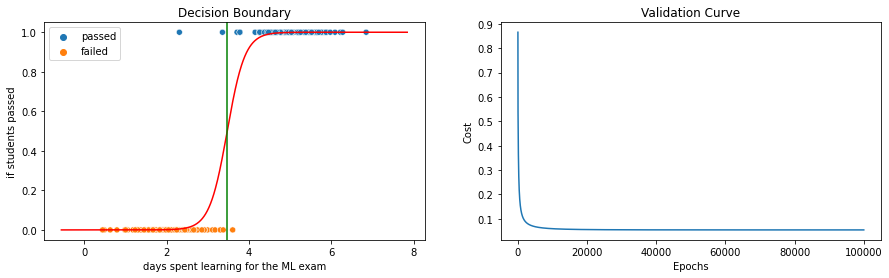

In [70]:
alpha = 0.1
num_epochs = 10000

bias_2d, thetas_2d, hist_2d = fit(X_train, y_train, alpha=0.1, num_epochs=10000, display_every=1000)

fig, ax = plt.subplots(ncols=2, figsize=(15,4))

# scatter plot
legend_map = {0: 'failed', 1: 'passed'}
ax[0] = sns.scatterplot(X, y, hue=pd.Series(y).map(legend_map), ax=ax[0])
ax[0].set_xlabel('days spent learning for the ML exam')
ax[0].set_ylabel('if students passed')
plot_decision_boundary(X, theta0, theta1, ax[0])

# validation curve
plot_validation_curve(hist["cost"], ax=ax[1])

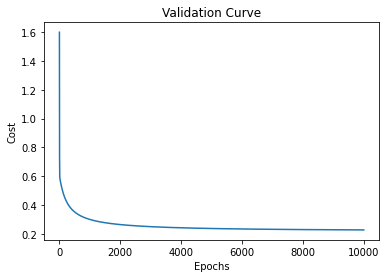

In [71]:
plot_validation_curve(hist_2d["cost"])

### Plot decision boundary

In [ ]:
print("decision boundary: %.3f + %.3f * x1 + %.3f * x2 = 0"
      % (bias_2d, thetas_2d[0], thetas_2d[1]))

x1 = np.array(X_train[:,0].T)
x2 = np.array(X_train[:,1].T)

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.set_xlabel('days spent learning')
ax.set_ylabel('prior knowledge (in days)')
color = ['blue' if l == 0 else 'green' for l in y_train]
scat = ax.scatter(x1, x2, color=color)

# inline function for decision boundary (unless vertical)
y_ = lambda x: ((-1)*(bias_2d + thetas_2d[0]*x) / thetas_2d[1])

def plot_line(y, data_pts):
    x_vals = [i for i in
              range(int(min(data_pts)-1),
                    int(max(data_pts))+2)]
    y_vals = [y(x) for x in x_vals]
    plt.plot(x_vals,y_vals, 'r')

plot_line(y_, x1)
plt.show()

### Evaluation
How should we evaluate our result? Of course this is highly dependent on both our original business problem and the data at hand. Questions such as
* Does the evaluation result need to be explainable to management, without using formulas and technical terms?
* Do we have a high class imbalance?
* Are False Positives and False Negatives equally bad? Does one of the two incur a high cost for our business and needs to be avoided?
* How do we rate the confidence? Do we want to penalise a classifier when it classifies a sample wrongly but is very sure of this result?

We will look at the metrics Accuracy and F1-Score.

> Predict the data on the test set.

In [ ]:
# y_pred = ...

In [ ]:
y_pred = predict(X_test, bias_2d, thetas_2d)
y_pred = (y_pred > 0.5).astype(int)
y_pred

#### Confusion Matrix
First we compute and plot the confusion matrix using the utility methods `compute_confusion_matrix` and `plot_confusion_matrix`.

In [ ]:
def compute_confusion_matrix(true, pred):
    # number of classes
    K = len(np.unique(true))
    c_mat = np.zeros((K, K))
    
    for i in range(len(true)):
        c_mat[int(true[i])][int(pred[i])] += 1
        
    return c_mat

def plot_confusion_matrix(cm):
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['True', 'False'],
                yticklabels=['True', 'False'],
                annot=True,ax=ax1,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()

In [ ]:
# cm = ...
# plot...

In [ ]:
cm = compute_confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

> Finally calculate and print the accuracy and the f1 score.

In [ ]:
def extract_scores(confusion_matrix):
    """
    Extracts the tp, tn, fp, fn from the
    confusion matrix.
    """
    # true positive
    tp = confusion_matrix[0][0]
    # true negative
    tn = confusion_matrix[1][1]
    # false positive
    fp = confusion_matrix[0][1]
    # false negative
    fn = confusion_matrix[1][0]
    
    return tp, tn, fp, fn

def accuracy_score(confusion_matrix):
    """
    Computes the accuracy from a confusion matrix.
    """
    tp, tn, fp, fn = extract_scores(confusion_matrix)
    acc = (tp + tn)/np.sum(confusion_matrix)
    
    return acc

def f1_score(confusion_matrix):
    """
    Computes the f1 score from a confusion matrix.
    """
    tp, tn, fp, fn = extract_scores(confusion_matrix)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*precision*recall)/(precision+recall)
    
    return f1

In [ ]:
# accuracy = ...
# f1 = ...

In [ ]:
accuracy = accuracy_score(cm)
f1 = f1_score(cm)

print ("test accuracy: %.2f" % accuracy)
print ("test f1 score: %.2f" % f1)